In [1]:
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv, norm, det

In [3]:
import os
os.chdir('/home/kei/Desktop/dpp/')

In [34]:
import sampler.dpp as dpp
import sampler.mcdpp as mcdpp
import sampler.utils as utils

In [4]:
# currently only support cpu mode
flag_gpu = False

lmbd = 1e-4
nTrn = 4000
nTot = 5000
data = pd.read_csv('data/ailerons.txt')[:nTot].values
trnY = data[:nTrn, -1]
tstY = data[nTrn:, -1]
pairwise_dists = squareform(pdist(data[:,:-1], 'euclidean'))
L = np.exp(-pairwise_dists ** 2 / 100 ** 2)
trnL = L[:nTrn, :nTrn]

In [36]:
def kl_multi_gaussian(mu0, S0, mu1, S1):
    
    assert(len(mu0)==len(mu1))
    assert(S0.shape==S1.shape)
    
    k = len(mu0)
    invS1 = inv(S1)
    tr = sum(invS1*S0)
    quad = (mu1-mu0) @ invS1 @ (mu1-mu0)
    logdet = np.log(det(S1)/det(S0))
    
    return 1/2 * (tr + quad - k + logdet)

In [37]:
def kl_gaussian(mu0, sigsq0, mu1, sigsq1):
    return 1/2 * (np.log(sigsq1)-np.log(sigsq0) + sigsq0/sigsq1 - 1 + (mu0-mu1)**2/sigsq1)

def kl_gaussian_vec(vec):
    [mu0, sigsq0, mu1, sigsq1] = list(vec)
    return kl_gaussian(mu0, sigsq0, mu1, sigsq1)

In [74]:
kl_gaussian_vec([0,1,0,1.1])

0.00220054444761697

# Full GP

In [116]:
sigma2 = lmbd*nTrn
inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
alpha = inv_mat @ trnY
Y_hat_full = L[:,:nTrn]@ alpha
Var_Y_hat_full = L - L[:,:nTrn] @ inv_mat @ L[:nTrn,:] + sigma2 * np.identity(L.shape[0])
error_full_trn = norm(Y_hat_full[:nTrn] - trnY)
error_full_tst = norm(Y_hat_full[nTrn:] - tstY)

In [125]:
# correct the scaling factor
scale = trnY.var()/sigma2
for i in range(1):
    dscale = - 1/(2*scale) + 1/(2*scale**2) * trnY @ alpha
    ddscale = (1/2*scale**2) - 1/(scale**3) * trnY @ alpha
    scale += dscale/ddscale

In [133]:
# scaled sigma
scale*sigma2

8.187274976311653e-08

# Nystrom GP

In [147]:
k_group = [20,30,50,70,100,150]
error_unif = np.zeros((4, len(k_group)))
error_dpp = np.zeros((4, len(k_group)))
error_mcdpp = np.zeros((4, len(k_group)))

kl_bound = np.zeros((3,len(k_group),))
n_job=10

for run_id in range(n_job):
    for k_idx in range(len(k_group)):
        k = k_group[k_idx]
        
        # Uniform sampling
        unif_smpl = np.random.permutation(nTrn)[:k]

        C = trnL[np.ix_(range(nTrn), unif_smpl)]
        W = C[np.ix_(unif_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_unif[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
        Var_Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), unif_smpl)].T + sigma2 * np.identity(L.shape[0])
        
        error_unif[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_unif[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:]*scale, 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]*scale
            ]).T
        error_unif[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        
        # DPP
        D, V = utils.get_eig(trnL, flag_gpu=flag_gpu)
        E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=flag_gpu)

        C = trnL[np.ix_(range(nTrn), dpp_smpl)]
        W = C[np.ix_(dpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_dpp[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), dpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_dpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_dpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:]*scale, 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]*scale
            ]).T
        error_dpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        kl_bound[0,k_idx] += np.trace(trnL - trnL_prime)**2
        kl_bound[1,k_idx] += (1/4*(1 - np.diag(Var_Y_hat)[nTrn:]/np.diag(Var_Y_hat_full)[nTrn:])**2).mean()
        kl_bound[2,k_idx] += (1/2*(Y_hat_full[nTrn:] - Y_hat[nTrn:])**2/np.diag(Var_Y_hat_full)[nTrn:]).mean()

        #MC-DPP
        #too slow to wait mixing
        mcdpp_smpl  = mcdpp.sample(L[:nTrn,:nTrn], mix_step=nTrn, k=k, flag_gpu=flag_gpu, silent=True)

        C = trnL[np.ix_(range(nTrn), mcdpp_smpl)]
        W = C[np.ix_(mcdpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_mcdpp[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), mcdpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_mcdpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_mcdpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:]*scale, 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]*scale
            ]).T
        error_mcdpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()


# Plot

In [148]:
%matplotlib inline

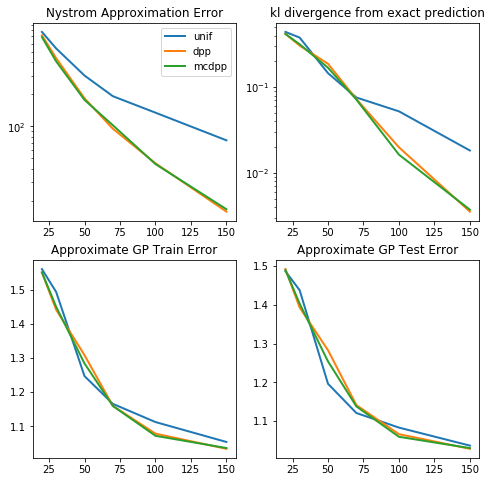

In [149]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title('Nystrom Approximation Error')
plt.plot(k_group, error_unif[0] / n_job, label='unif', lw=2)
plt.plot(k_group, error_dpp[0] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[0] / n_job, label='mcdpp', lw=2)
plt.yscale('log')
plt.legend()
#plt.savefig('fig/nystrom', bbox_inches='tight')

plt.subplot(2,2,2)
plt.title('kl divergence from exact prediction')
plt.plot(k_group, error_unif[3] / n_job, label='unif', lw=2)
plt.plot(k_group, error_dpp[3] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[3] / n_job, label='mcdpp', lw=2)
#plt.plot(k_group, kl_bound[0] / 4000**2/n_job, label='bound for mcdpp', lw=2)
plt.plot(k_group, kl_bound[1] / n_job * 2, label='bound for mcdpp', lw=2)
plt.plot(k_group, kl_bound[2], label='bound for mcdpp', lw=2)

plt.yscale('log')


plt.subplot(2,2,3)
plt.title('Approximate GP Train Error')
plt.plot(k_group, error_unif[1] / n_job/error_full_trn, label='unif', lw=2)
plt.plot(k_group, error_dpp[1] / n_job/error_full_trn, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[1] / n_job/error_full_trn, label='mcdpp', lw=2)
#plt.yscale('log')
plt.subplot(2,2,4)
plt.title('Approximate GP Test Error')
plt.plot(k_group, error_unif[2] / n_job/error_full_tst, label='unif', lw=2)
plt.plot(k_group, error_dpp[2] / n_job/error_full_tst, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[2] / n_job/error_full_tst, label='mcdpp', lw=2)
#plt.yscale('log')

plt.savefig('fig/gp_regression', bbox_inches='tight')

In [139]:
tmp[:3]

array([[-5.42302767e-04,  8.83861724e-15, -6.25933422e-04,
         8.71781935e-15],
       [-9.78831048e-04,  8.43509786e-15, -9.63587820e-04,
         8.42431744e-15],
       [-8.62507764e-04,  8.48201139e-15, -8.27387960e-04,
         8.45428228e-15]])

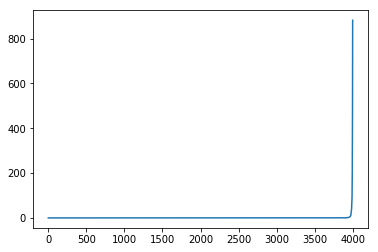

In [10]:
# distribution of eigen values
plt.plot(D)

# Beyond DPP, kl Divergence of Latent Variables

In [12]:
k_group = [20,30,50,70,100]
error_unif = np.zeros((4, len(k_group)))
error_dpp = np.zeros((4, len(k_group)))
error_mcdpp = np.zeros((4, len(k_group)))

for run_id in range(10):
    for k_idx in range(len(k_group)):
        k = k_group[k_idx]
        
        # Uniform sampling
        unif_smpl = np.random.permutation(nTrn)[:k]

        C = trnL[np.ix_(range(nTrn), unif_smpl)]
        W = C[np.ix_(unif_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_unif[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
        Var_Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), unif_smpl)].T# + sigma2 * np.identity(L.shape[0])
        
        error_unif[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_unif[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_unif[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        
        # DPP
        D, V = utils.get_eig(trnL, flag_gpu=flag_gpu)
        E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=flag_gpu)

        C = trnL[np.ix_(range(nTrn), dpp_smpl)]
        W = C[np.ix_(dpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_dpp[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), dpp_smpl)].T# + sigma2 * np.identity(L.shape[0])
        error_dpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_dpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_dpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()

        #MC-DPP
        #too slow to wait mixing
        mcdpp_smpl  = mcdpp.sample(L[:nTrn,:nTrn], mix_step=k*nTrn//100, k=k, flag_gpu=flag_gpu, silent=True)

        C = trnL[np.ix_(range(nTrn), mcdpp_smpl)]
        W = C[np.ix_(mcdpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_mcdpp[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), mcdpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_mcdpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_mcdpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_mcdpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        


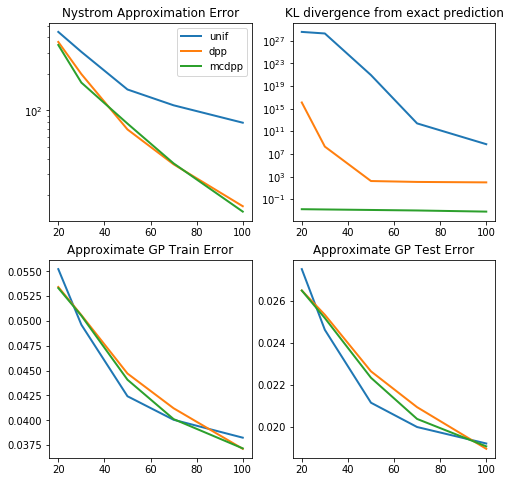

In [13]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title('Nystrom Approximation Error')
plt.plot(k_group, error_unif[0] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[0] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[0] / 5., label='mcdpp', lw=2)
plt.yscale('log')
plt.legend()
#plt.savefig('fig/nystrom', bbox_inches='tight')

plt.subplot(2,2,2)
plt.title('kl divergence from exact prediction')
plt.plot(k_group, error_unif[3] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[3] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[3] / 5., label='mcdpp', lw=2)
plt.plot([])
plt.yscale('log')


plt.subplot(2,2,3)
plt.title('Approximate GP Train Error')
plt.plot(k_group, error_unif[1] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[1] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[1] / 5., label='mcdpp', lw=2)
plt.subplot(2,2,4)
plt.title('Approximate GP Test Error')
plt.plot(k_group, error_unif[2] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[2] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[2] / 5., label='mcdpp', lw=2)

plt.savefig('fig/gp_regression', bbox_inches='tight')

In [27]:
k_group = [20,30,50,70,100]
error_unif = np.zeros((4, len(k_group)))
error_dpp = np.zeros((4, len(k_group)))
error_mcdpp = np.zeros((4, len(k_group)))

for run_id in range(10):
    for k_idx in range(len(k_group)):
        k = k_group[k_idx]
        
        # Uniform sampling
        unif_smpl = np.random.permutation(nTrn)[:k]

        C = trnL[np.ix_(range(nTrn), unif_smpl)]
        W = C[np.ix_(unif_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_unif[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
        Var_Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), unif_smpl)].T + sigma2 * np.identity(L.shape[0])
        
        error_unif[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_unif[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:],
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
            ]).T
        error_unif[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        
        # DPP
        D, V = utils.get_eig(trnL, flag_gpu=flag_gpu)
        E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=flag_gpu)

        C = trnL[np.ix_(range(nTrn), dpp_smpl)]
        W = C[np.ix_(dpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_dpp[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), dpp_smpl)].T# + sigma2 * np.identity(L.shape[0])
        error_dpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_dpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:],
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
            ]).T
        error_dpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()

        #MC-DPP
        #too slow to wait mixing
        mcdpp_smpl  = mcdpp.sample(L[:nTrn,:nTrn], mix_step=k*nTrn//100, k=k, flag_gpu=flag_gpu, silent=True)

        C = trnL[np.ix_(range(nTrn), mcdpp_smpl)]
        W = C[np.ix_(mcdpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_mcdpp[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), mcdpp_smpl)].T# + sigma2 * np.identity(L.shape[0])
        error_mcdpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_mcdpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:],
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
            ]).T
        error_mcdpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        


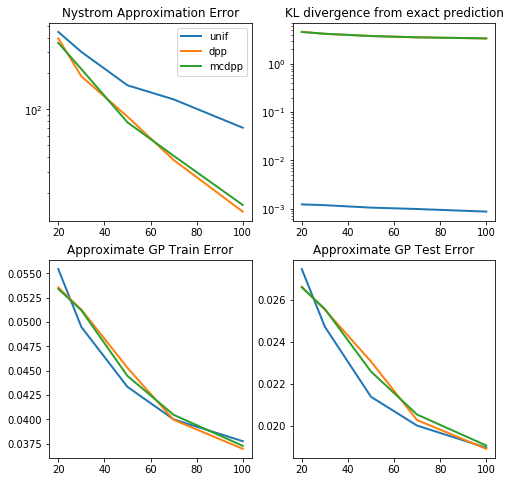

In [28]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title('Nystrom Approximation Error')
plt.plot(k_group, error_unif[0] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[0] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[0] / 5., label='mcdpp', lw=2)
plt.yscale('log')
plt.legend()
#plt.savefig('fig/nystrom', bbox_inches='tight')

plt.subplot(2,2,2)
plt.title('kl divergence from exact prediction')
plt.plot(k_group, error_unif[3] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[3] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[3] / 5., label='mcdpp', lw=2)
plt.plot([])
plt.yscale('log')


plt.subplot(2,2,3)
plt.title('Approximate GP Train Error')
plt.plot(k_group, error_unif[1] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[1] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[1] / 5., label='mcdpp', lw=2)
#plt.yscale('log')
plt.subplot(2,2,4)
plt.title('Approximate GP Test Error')
plt.plot(k_group, error_unif[2] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[2] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[2] / 5., label='mcdpp', lw=2)
#plt.yscale('log')

plt.savefig('fig/gp_regression', bbox_inches='tight')

In [9]:
k_group = [20,30,50,70,100]

def simulate_once(i):
    
    import sys
    sys.path.insert(0, "/home/kei/Desktop/dpp/")

    np.random.seed(i)
    
    error_unif = np.zeros((4, len(k_group)))
    error_dpp = np.zeros((4, len(k_group)))
    error_mcdpp = np.zeros((4, len(k_group)))

    kl_bound = np.zeros((3,len(k_group),))

    for k_idx in range(len(k_group)):
        k = k_group[k_idx]
        
        # Uniform sampling
        unif_smpl = np.random.permutation(nTrn)[:k]

        C = trnL[np.ix_(range(nTrn), unif_smpl)]
        W = C[np.ix_(unif_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_unif[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
        Var_Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), unif_smpl)].T + sigma2 * np.identity(L.shape[0])
        
        error_unif[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_unif[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:]*scale, 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]*scale
            ]).T
        error_unif[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        
        # DPP
        D, V = utils.get_eig(trnL_0, flag_gpu=flag_gpu)
        E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=flag_gpu)

        C = trnL[np.ix_(range(nTrn), dpp_smpl)]
        W = C[np.ix_(dpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_dpp[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), dpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_dpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_dpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:]*scale, 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]*scale
            ]).T
        error_dpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()
        kl_bound[0,k_idx] += np.trace(trnL - trnL_prime)**2
        kl_bound[1,k_idx] += (1/4*(1 - np.diag(Var_Y_hat)[nTrn:]/np.diag(Var_Y_hat_full)[nTrn:])**2).mean()
        kl_bound[2,k_idx] += (1/2*(Y_hat_full[nTrn:] - Y_hat[nTrn:])**2/np.diag(Var_Y_hat_full)[nTrn:]).mean()

        #MC-DPP
        #too slow to wait mixing
        mcdpp_smpl  = mcdpp.sample(trnL_0, mix_step=nTrn, k=k, flag_gpu=flag_gpu, silent=True)

        C = trnL[np.ix_(range(nTrn), mcdpp_smpl)]
        W = C[np.ix_(mcdpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_mcdpp[0,k_idx] += np.trace(trnL - trnL_prime) #norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), mcdpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_mcdpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_mcdpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:]*scale, 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]*scale
            ]).T
        error_mcdpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=kl_gaussian_vec).mean()

    return [error_unif, error_dpp, error_mcdpp, kl_bound]

In [10]:
>>> from math import sqrt
>>> from joblib import Parallel, delayed
>>> Parallel(n_jobs=2)(delayed(simulate_once)(i) for i in range(10))
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

NameError: name 'sigma2' is not defined

# Tensorflow 

import tensorflow as tf


tf.reset_default_graph()
tf_trnY = tf.convert_to_tensor(trnY.reshape([nTrn,1]),name='trnY')
tf_trnL = tf.convert_to_tensor(trnL,name='trnL')
tf_scale = tf.get_variable('logscale', dtype=tf.float64, initializer=np.float64(trnY.var()/(nTrn*lmbd)))**2
tf_tao2 = tf.get_variable('logtao2', dtype=tf.float64, initializer=np.float64(nTrn*lmbd))**2
tf_C = tf_scale * tf_trnL + tf_tao2 * tf.eye(nTrn, dtype=tf.float64)
tf_C_inv = tf.linalg.inv(tf_C)

tf_logP = - 1/2 * tf.log(tf.linalg.det(tf_C)) - 1/2 * tf.squeeze(tf.transpose(tf_trnY) @ tf_C_inv @ tf_trnY)

#tf_dscale = tf.gradients(-tf_logP, tf_scale)[0]
#tf_ddscale = tf.gradients(tf_dscale, tf_scale)[0]
#tf_dtao2 = tf.gradients(-tf_logP, tf_tao2)[0]
#tf_ddtao2 = tf.gradients(tf_dtao2, tf_scale)[0]

init = tf.global_variables_initializer()
#alpha = 0.1
#update = [
#    tf_scale.assign_add( - alpha * tf_dscale/tf_ddscale),
#    tf_tao2.assign_add( - alpha * tf_tao2/tf_ddtao2)
#]

opt = tf.train.GradientDescentOptimizer(0.0001)
update_step = opt.minimize(-tf_logP)
init = tf.global_variables_initializer()

"""with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:   
    sess.run(init)
    for i in range (10):
        sess.run(update_step)
    scale = sess.run(tf_scale)[0]
    tao  = sess.run(tf_tao2)[0]
"""

# Hyperparameter Tuning

# Hyperparemeter Tuning
[scale, sigma2] = [trnY.var()/(nTrn*lmbd), nTrn*lmbd]
X = np.array([scale, sigma2])

for i in range(100):

    inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
    alpha = inv_mat @ trnY
    A = trnY@alpha
    B = sum(alpha**2)
    C = alpha@inv_mat@alpha
    D = np.trace(inv_mat)
    E = np.sum(inv_mat*inv_mat) #np.trace(inv_mat@inv_mat)

    dscale   = - nTrn/(2*scale) + 1/(2*scale**2) * A
    dsigma2  = - 1/2 * D + 1/(2*scale) * B
    ddscale  = nTrn/(2*scale**2) - 1/(scale**3) * A
    ddsigma2 =   1/2 * E - 1/scale * C
    ddcross  = - 1/(2*scale**2) *B
    dX = np.array([dscale, dsigma2])
    H = np.array([[ddscale, 0],[0, ddsigma2]])
    H_inv = np.linalg.inv(H)

    X -= 0.01 * H_inv@dX
    [scale, sigma2] = list(X)


X

H_inv@dX

Find optimal sigma(ralative)

->go to 1<<sigma2

->better fit for train data with more penalty

#sigma2 = nTrn*lmbd
for i in range(40):
    inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
    A = inv_mat@trnL
    dsigma2 = 2*trnY@inv_mat@inv_mat@(np.eye(nTrn)-inv_mat@trnL)@trnY
    ddsigma2 = - 2*trnY@inv_mat@inv_mat@inv_mat@(2*np.eye(nTrn)-3*inv_mat@trnL)@trnY
    sigma2 -= 0.1*dsigma2/ddsigma2

# parallelization

from joblib import Parallel, delayed
x
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass

Parallel(n_jobs=4)(delayed(simulate_once)(i) for i in range(4))

import tensorflow as tf


tf.reset_default_graph()
tf_trnY = tf.convert_to_tensor(trnY.reshape([nTrn,1]),name='trnY')
tf_trnL = tf.convert_to_tensor(trnL,name='trnL')
tf_scale = tf.get_variable('logscale', dtype=tf.float64, initializer=np.float64(trnY.var()/(nTrn*lmbd)))**2
tf_tao2 = tf.get_variable('logtao2', dtype=tf.float64, initializer=np.float64(nTrn*lmbd))**2
tf_C = tf_scale * tf_trnL + tf_tao2 * tf.eye(nTrn, dtype=tf.float64)
tf_C_inv = tf.linalg.inv(tf_C)

tf_logP = - 1/2 * tf.log(tf.linalg.det(tf_C)) - 1/2 * tf.squeeze(tf.transpose(tf_trnY) @ tf_C_inv @ tf_trnY)

#tf_dscale = tf.gradients(-tf_logP, tf_scale)[0]
#tf_ddscale = tf.gradients(tf_dscale, tf_scale)[0]
#tf_dtao2 = tf.gradients(-tf_logP, tf_tao2)[0]
#tf_ddtao2 = tf.gradients(tf_dtao2, tf_scale)[0]

init = tf.global_variables_initializer()
#alpha = 0.1
#update = [
#    tf_scale.assign_add( - alpha * tf_dscale/tf_ddscale),
#    tf_tao2.assign_add( - alpha * tf_tao2/tf_ddtao2)
#]

opt = tf.train.GradientDescentOptimizer(0.0001)
update_step = opt.minimize(-tf_logP)
init = tf.global_variables_initializer()

"""with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:   
    sess.run(init)
    for i in range (10):
        sess.run(update_step)
    scale = sess.run(tf_scale)[0]
    tao  = sess.run(tf_tao2)[0]
"""

# Hyperparameter Tuning

# Hyperparemeter Tuning
[scale, sigma2] = [trnY.var()/(nTrn*lmbd), nTrn*lmbd]
X = np.array([scale, sigma2])

for i in range(100):

    inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
    alpha = inv_mat @ trnY
    A = trnY@alpha
    B = sum(alpha**2)
    C = alpha@inv_mat@alpha
    D = np.trace(inv_mat)
    E = np.sum(inv_mat*inv_mat) #np.trace(inv_mat@inv_mat)

    dscale   = - nTrn/(2*scale) + 1/(2*scale**2) * A
    dsigma2  = - 1/2 * D + 1/(2*scale) * B
    ddscale  = nTrn/(2*scale**2) - 1/(scale**3) * A
    ddsigma2 =   1/2 * E - 1/scale * C
    ddcross  = - 1/(2*scale**2) *B
    dX = np.array([dscale, dsigma2])
    H = np.array([[ddscale, 0],[0, ddsigma2]])
    H_inv = np.linalg.inv(H)

    X -= 0.01 * H_inv@dX
    [scale, sigma2] = list(X)


X

H_inv@dX

Find optimal sigma(ralative)

->go to 1<<sigma2

->better fit for train data with more penalty

#sigma2 = nTrn*lmbd
for i in range(40):
    inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
    A = inv_mat@trnL
    dsigma2 = 2*trnY@inv_mat@inv_mat@(np.eye(nTrn)-inv_mat@trnL)@trnY
    ddsigma2 = - 2*trnY@inv_mat@inv_mat@inv_mat@(2*np.eye(nTrn)-3*inv_mat@trnL)@trnY
    sigma2 -= 0.1*dsigma2/ddsigma2

# parallelization

from joblib import Parallel, delayed
x
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass

Parallel(n_jobs=4)(delayed(simulate_once)(i) for i in range(4))